In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import seaborn as sns

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
Train = pd.read_csv('train.csv')
Test = pd.read_csv('test.csv')
AllData=[Train,Test]
Train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Overview

In [3]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Ticket has  holds no meaningful information so we should drop it.
Cabin has a lot of Nan's which may be meaningfull (not everyone in the ship had a cabin which may contribute with survival. Age and sex may also be meaningfull (women and children first). The Age NaN's can be extrapolated (maybe)

In [4]:
for dataset in AllData:
    dataset.drop('Ticket', axis=1, inplace=True)

# Correlation between features

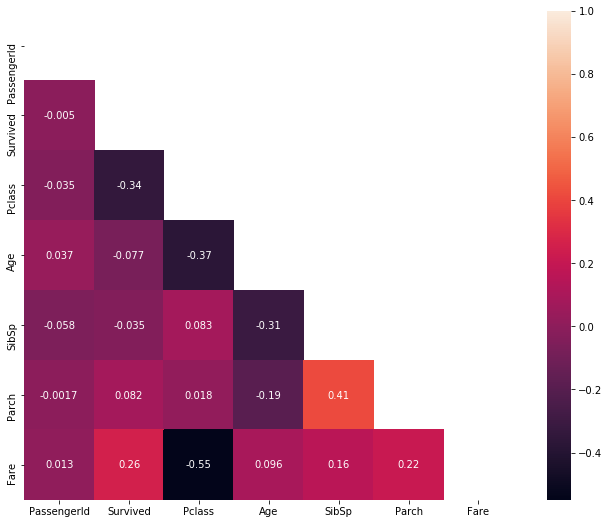

In [5]:
TrainDataC = Train.corr()
#correlation heatmap, masking the upper part as its redundant
mask = np.zeros_like(TrainDataC , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(12,9))
sns.heatmap(TrainDataC, annot=True,square=True, mask=mask)

Pclass and fare correlate with survival. Age not so much surprisingly. Pclass correlates with fare, not surprinsingly. The high correlation between Parch and SibSp may be due to the families travelling together.

## Age
  
### Directly looking into age (as an average per survival)

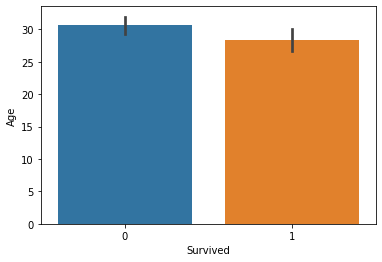

In [6]:
sns.barplot('Survived', 'Age', data=Train)

This is interesting as age (as an average) doesn't look very different.  Lets separate the age into groups:

In [7]:
Age_Data = Train.loc[:,['PassengerId','Age', 'Survived']]
Age_Data['Age'].fillna(-0.1, inplace=True)
bins= [-100, 0, 10, 20, 30, 40, 50, 60, np.inf]
labels = [0,1,2,3,4,5,6,7]
#labels = ['Unknown','0-10','10-20','20-30','30-40','40-50','50-60','>60']
Age_Data['AgeGroup'] = pd.cut(Age_Data['Age'], bins=bins, labels=labels, right=False)

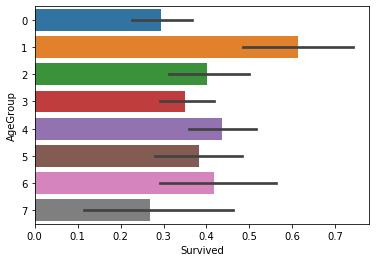

In [8]:
sns.barplot('Survived', 'AgeGroup', data=Age_Data)

If we replace Age by the median

In [9]:
Age_Data['Age'].replace(-0.1, np.nan, inplace=True)
Age_Data['Age'].fillna((Age_Data['Age'].median()), inplace=True)


In [10]:
bins= [0, 10, 20, 30, 40, 50, 60, np.inf]
labels = [1,2,3,4,5,6,7]
#labels = ['Unknown','0-10','10-20','20-30','30-40','40-50','50-60','>60']
Age_Data['AgeGroup'] = pd.cut(Age_Data['Age'], bins=bins, labels=labels, right=False)

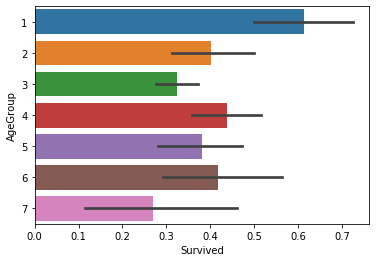

In [11]:
sns.barplot('Survived', 'AgeGroup', data=Age_Data)

This makes quite a lot of difference but younger seem to be less prone to die still. Lets apply this to our data

In [12]:
for dataset in AllData:
    dataset['AgeGroup'] = pd.cut(Age_Data['Age'], bins=bins, labels=labels, right=False)
    dataset['Age'].fillna((Age_Data['Age'].median()), inplace=True)

# Gender

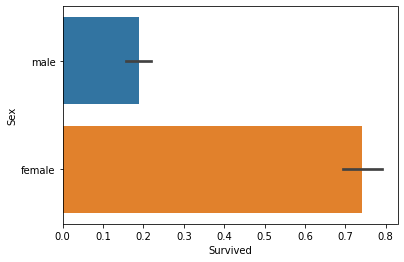

In [13]:
sns.barplot(x='Survived', y='Sex', data=Train)

Women first indeed. Lets encode this categorical data.

In [14]:
for dataset in AllData:
    dataset['Sex'].replace( ['male','female'], [0,1],inplace = True)

In [15]:
print(Train[['AgeGroup', 'Survived']].groupby(['AgeGroup'], as_index = False).mean())


  AgeGroup  Survived
0        1  0.612903
1        2  0.401961
2        3  0.324937
3        4  0.437126
4        5  0.382022
5        6  0.416667
6        7  0.269231


# SibSp and Parch

This can be concatenated in a new feature called family size (otherwise it may get confusing)  
Family size = SibSp + Parch + 1

In [16]:
for dataset in AllData:
    dataset['FamilySize']  = dataset['SibSp'] + dataset['Parch'] + 1

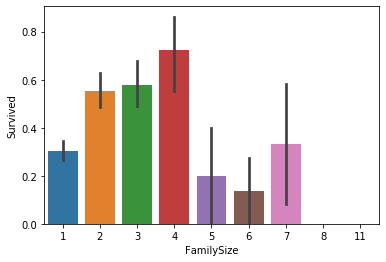

In [17]:
sns.barplot(x=Train.FamilySize, y=Train.Survived)

4 is the magic number.

# Fare

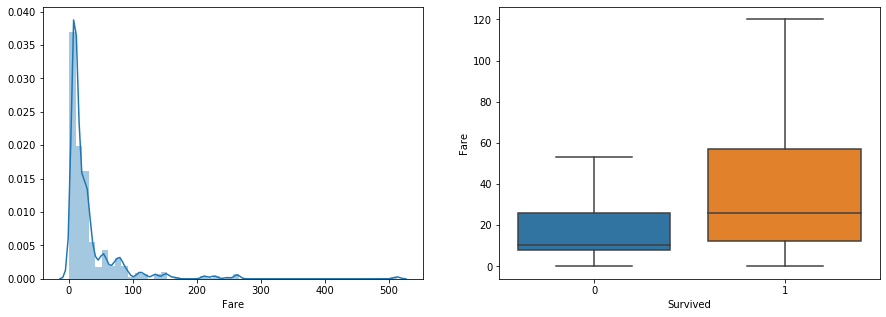

In [18]:
fx, axes = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(Train.Fare, ax=axes[0])
sns.boxplot('Survived', 'Fare', data=Train, showfliers = False, ax=axes[1]) 

Fare is indeed correlated with survival. The distribution is very shifted to the left (more people payed less) and has a longtail distribution. Lets look more into this by dividing the data.

We can categorize the data by dividing it by a number and returning an int. Also there is an NA in the test set which we should substitute by the median.

In [19]:
Test['Fare'].replace(np.nan, Test['Fare'].mean(axis=0), inplace=True)
for dataset in AllData:
    dataset.Fare = (dataset.Fare /20).astype(np.int64) + 1 

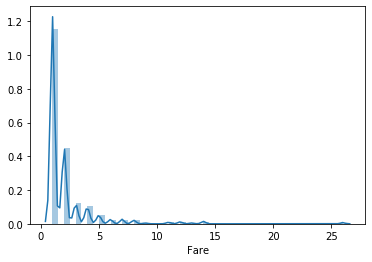

In [20]:
sns.distplot(Train.Fare)

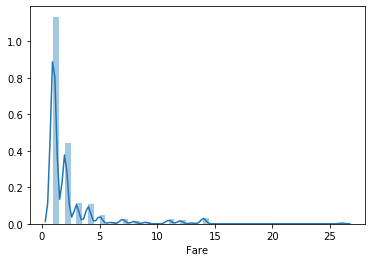

In [21]:
sns.distplot(Test.Fare)

This looks neater. Again, higher fare, higher survival changes

# Cabin

Keeping with a simplistic approach, having a cabin number may be by itself correlated with higher social status and consequently higher survivability.

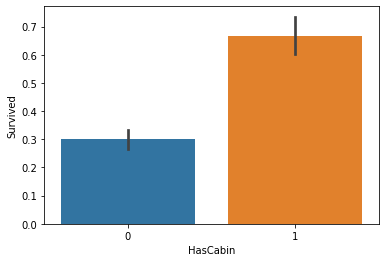

In [22]:
for dataset in AllData:
    dataset["HasCabin"] = dataset["Cabin"].notnull().astype('int')
    
sns.barplot(x="HasCabin", y="Survived", data=Train)
plt.show()

Success, having cabin tends to lead to survival. We have the data to reflect this then by creating the 'HasCabin' feature

In [23]:
Train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,AgeGroup,FamilySize,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,1,NaN,S,3,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,4,C85,C,4,2,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,1,NaN,S,3,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,3,C123,S,4,2,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,1,NaN,S,4,1,0


# Port of embark

In [24]:
Train.Embarked.describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [25]:
print(Train.Embarked.isnull().sum(), Test.Embarked.isnull().sum())

2 0


Substituting nan's with the most representative - S

In [26]:
Train['Embarked'] = Train['Embarked'].fillna('S')

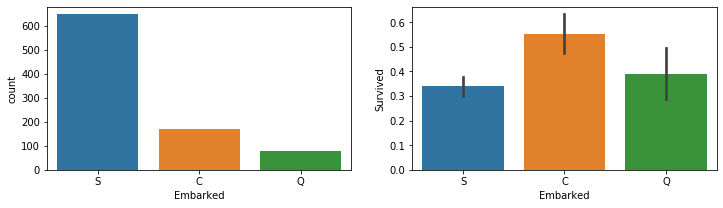

In [27]:
fx, axes = plt.subplots(1, 2, figsize=(12,3))

sns.countplot(x=Train.Embarked, ax=axes[0])
sns.barplot(x=Train.Embarked, y=Train.Survived, ax=axes[1])

Turning this into numerical.  
1 -> S  
2 -> C  
3 -> Q  

In [28]:
for dataset in AllData:
    dataset['Embarked'] = dataset['Embarked'].map({'S': 1, 'C': 2, 'Q': 3}).astype(int)

# Name

We can extrapolate a new feature - title - from the names.

In [29]:
for dataset in AllData:
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+\\w\\.)+', expand=False)
    dataset['Title'] = dataset.Title.str.replace('.','')



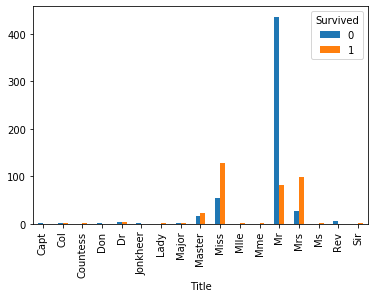

In [30]:
pd.crosstab(Train['Title'], Train['Survived']).plot(kind='bar')
#print(Train[['Title', 'Survived']].groupby(['Title'], as_index = False).mean())

Losts of titles which may induce overfitting. Lets agregate the data:

In [31]:
maping={'Master':1, 'Miss':2,'Mr':3,'Mrs':4, 'Other':5,'Royals':6}
for dataset in AllData:
    dataset['Title'] = dataset.Title.replace(['Lady','Countess','Sir'], 'Royals')
    dataset['Title'] = dataset.Title.replace(['Capt','Col','Major','Dr', 'Jonkheer','Don','Rev'], 'Other')
    dataset['Title'] = dataset.Title.replace('Mme','Mrs')
    dataset['Title'] = dataset.Title.replace(['Mlle','Ms'],'Miss')
    dataset['Title'] = dataset.Title.map(maping)
    

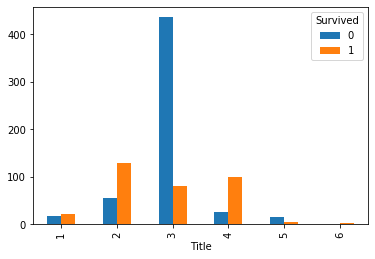

In [32]:
pd.crosstab(Train['Title'], Train['Survived']).plot(kind='bar')

We also mapped the categorical features into numeric
  
1 - Master  
2 - Miss  
3 - Mr  
4 - Mrs  
5 - Other  
6 - Royals  

In [33]:
Test['Title']=Test['Title'].fillna(5)

# Data Preparation

In [34]:
Train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,AgeGroup,FamilySize,HasCabin,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,1,NaN,1,3,2,0,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,4,C85,2,4,2,1,4
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,1,NaN,1,3,1,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,3,C123,1,4,2,1,4
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,1,NaN,1,4,1,0,3


In [35]:
Test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,AgeGroup,FamilySize,HasCabin,Title
0,892,3,"Kelly, Mr. James",0,34.5,0,0,1,NaN,3,3,1,0,3.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,1,NaN,1,4,2,0,4.0
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,1,NaN,3,3,1,0,3.0
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,1,NaN,1,4,1,0,3.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,1,NaN,1,4,3,0,4.0


In [36]:
X_train = Train[['Pclass', 'Sex', 'Fare', 'Embarked', 'AgeGroup', 'FamilySize', 'HasCabin', 'Title']]
X_test = Test[['Pclass', 'Sex', 'Fare', 'Embarked', 'AgeGroup', 'FamilySize', 'HasCabin', 'Title']]
Y_train = Train['Survived']

In [37]:
print(X_train.shape, X_test.shape, Y_train.shape)

(891, 8) (418, 8) (891,)


# Model comparisons

In [38]:
#Logistic reg
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
classifier.score(X_train, Y_train)

0.8002244668911336

Checking feature coefficient:

In [39]:
coef = pd.DataFrame(X_train.columns.delete(0))
coef.columns = ['Feature']
coef['Corr'] = pd.Series(classifier.coef_[0])
coef.sort_values(by='Corr', ascending=False)

,Feature,Corr
1,Fare,2.640000
6,Title,0.621919
3,AgeGroup,0.190970
2,Embarked,0.025116
5,HasCabin,-0.203844
4,FamilySize,-0.292588
0,Sex,-0.877705


    Fare is very important for some reason. We may have overfitting

In [40]:
#SVC

svc=SVC()
svc.fit(X_train,Y_train)
Y_pred = svc.predict(X_test)
svc.score(X_train, Y_train)

0.8338945005611672

In [41]:
#KNN

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,Y_train)
Y_pred = knn.predict(X_test)
knn.score(X_train, Y_train)

0.8518518518518519

In [42]:
#Naive Bayes

NB = GaussianNB()
NB.fit(X_train, Y_train)
Y_pred = NB.predict(X_test)
NB.score(X_train, Y_train)

0.7890011223344556

In [43]:
#gradient descent

sgd = SGDClassifier()
sgd.fit(X_train,Y_train)
Y_pred = NB.predict(X_test)
sgd.score(X_train, Y_train)


0.7003367003367004

In [44]:
#Decision Tree

DT = DecisionTreeClassifier()
DT.fit(X_train,Y_train)
Y_pred = DT.predict(X_test)
DT.score(X_train, Y_train)

0.9068462401795735

In [45]:
# Rand Forest

RF = RandomForestClassifier()
RF.fit(X_train, Y_train)
Y_pred = RF.predict(X_test)
RF.score(X_train, Y_train)

0.9068462401795735

   While DT and RF scored the same, we will select RF because they overfit less to the training set (which is quite small)

# Hyperparameter Tuning

In [46]:
#param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
#from sklearn.model_selection import GridSearchCV, cross_val_score

#rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

#clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)

#clf.fit(X_train, Y_train)

#clf.best_params_

In [47]:
#post tuning
random_forest = RandomForestClassifier(criterion = "entropy", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 25,   
                                       n_estimators=700, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

score=random_forest.score(X_train, Y_train)
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 83.39 %


In [48]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=20)
confusion_matrix(Y_train, predictions)

array([[505,  44],
       [105, 237]], dtype=int64)

In [49]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

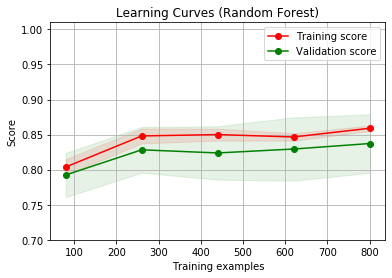

In [50]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(random_forest, X_train, Y_train, cv=10, scoring = "accuracy")
# Plot learning curves
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

title = "Learning Curves (Random Forest)"
cv = 10
plot_learning_curve(random_forest, title, X_train, Y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=1);

In [51]:
submission = pd.DataFrame({
        "PassengerId": Test['PassengerId'],
        "Survived": Y_prediction
    })
submission.to_csv('submission_NEW.csv', index=False)